#Preprocesiranje

In [ ]:
pip install pulp

In [19]:
import pandas as pd
import pulp
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
import os
from sklearn import tree
from sklearn import ensemble
import math
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import string
from sklearn.model_selection import StratifiedKFold

In [3]:
def parse_one_file1(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks):
  df = pd.read_csv(file_path)
  df = df.drop(columns=columns_for_drop)

  teams = pd.read_csv(teams_path)
  columns_teams = list(teams.columns)
  columns_teams.remove('id')
  columns_teams.remove('strength')
  teams = teams.drop(columns=columns_teams)


  payers_raw = pd.read_csv(payers_raw_path)
  columns_players_raw = list(payers_raw.columns)
  columns_players_raw.remove('id')
  columns_players_raw.remove('element_type')
  payers_raw = payers_raw.drop(columns=columns_players_raw)


  df = pd.merge(df, teams, left_on='opponent_team', right_on='id', how='left').drop(['opponent_team','id'],axis=1)
  df = pd.merge(df, payers_raw, left_on='element', right_on='id', how='left').drop(['element','id'],axis=1)
  df['minutes'] = np.where(df['minutes']>=60, 1, 0)

  df_element_type = df['element_type']
  df_strength = df['strength']
  df_total_points = df['total_points']
  df_was_home = df['was_home']
  dfs_only_last_week = df[only_last_week]
  df_left = df.drop(columns=(['element_type','strength','was_home','total_points']+only_last_week))
  df_right = pd.concat([df_element_type,df_strength, df_was_home,df_total_points], axis=1)

  #     print(df_left.head)
  columns_left = df_left.columns
  columns_middle = dfs_only_last_week.columns
  columns_right = df_right.columns

  new_data = []
  data = df_left.to_numpy()

  n = data.shape[0]
  d = (last_weeks)*((last_weeks+1)/2)
  for i in range(last_weeks,n):
      u = 1
      inner_array = np.copy(data[i-last_weeks])
      inner_array = inner_array*(u/d)
      for j in range(i-last_weeks+1,i):
          u+=1
          inner_array += data[j]*(u/d)
          
  #         inner_array /= last_weeks
      inner_array = np.append(inner_array,np.array([x for x in dfs_only_last_week.iloc[i-1]]))
      inner_array = np.append(inner_array,np.array([df_right['element_type'][i],df_right['strength'][i],df_right['was_home'][i],df_right['total_points'][i]]))
      new_data.append(inner_array)
  columns = np.append(np.array(columns_left),np.array(columns_middle))
  columns = np.append(np.array(columns),np.array(columns_right))
  return pd.DataFrame(new_data,columns=columns)

In [4]:
def parse_data(root_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks = 5):
    data = pd.DataFrame()
    for root, subdirs, files in os.walk(root_path):
        file_path = None
        for file in files:
          if(file == "gw.csv"):
            file_path = os.path.join(root,file)
            #print(file_path)
            new_data = parse_one_file1(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks)
            data = pd.concat([new_data,data],ignore_index=True)
    return data

In [ ]:
!unrar x "./players.rar" "."

In [6]:
columns_for_drop = ['bps','fixture','ict_index','kickoff_time','round','transfers_in','transfers_out']
only_last_week = ['creativity','influence','threat']
data = parse_data('./players/','teams.csv','players_raw.csv',columns_for_drop,only_last_week,5)
data.head()

,assists,bonus,clean_sheets,goals_conceded,goals_scored,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,transfers_balance,value,yellow_cards,creativity,influence,threat,element_type,strength,was_home,total_points
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8310.200000,1.266667,0.600000,-1471.400000,49.200000,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7183.066667,1.866667,0.600000,-1356.600000,48.733333,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6194.066667,1.600000,1.066667,-1089.933333,48.400000,0.0,0.0,0.0,0.0,3.0,4.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5459.600000,2.400000,1.133333,-793.600000,48.200000,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4950.133333,2.066667,1.133333,-540.533333,48.066667,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0


In [ ]:
# Raspodela poena u podacima
# for u in np.unique(data['total_points']):
#     print(u,sum(u == data['total_points']))

In [7]:
x = pd.get_dummies(data,columns=['was_home','element_type'])
x = data.drop(columns=['total_points'])

In [8]:
y = data['total_points']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


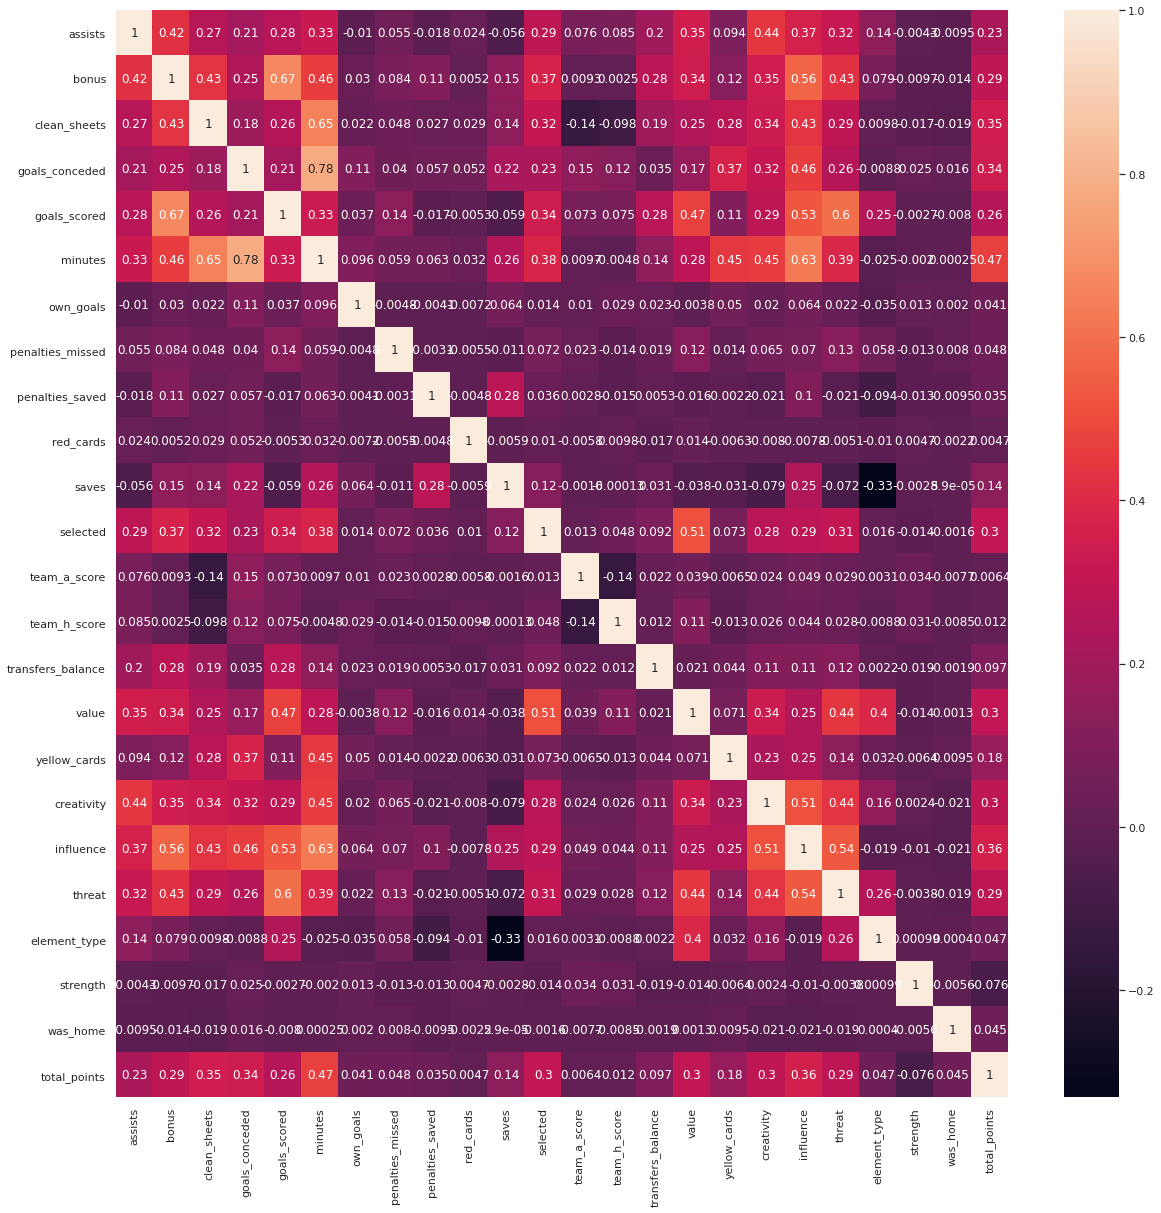

In [ ]:
corrmax = data.corr()
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmax, annot = True)

In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.25, random_state = 7)

scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [10]:
def selectParamsAndEvaluateConfigurations(model, model_name, params):


  skf = StratifiedKFold(n_splits=5, random_state = 7, shuffle = True)

  grid_model = model_selection.GridSearchCV(model, param_grid=params, scoring='r2', return_train_score=True, cv = skf)
  grid_model.fit(x_train_scaled, y_train)

  print("Model name: " + model_name)
  print(grid_model.best_score_)
  print(grid_model.best_params_)
  print("-----------------------------")

  return grid_model.best_score_

#LinearnaRegresija

In [ ]:
lr = linear_model.LinearRegression()
lr.fit(x_train_scaled, y_train)
y_pred = lr.predict(x_test_scaled)
lr_best_score = metrics.r2_score(y_test, y_pred)
print('R2: ' + str(metrics.r2_score(y_test, y_pred)))
print('MSE: ' + str(metrics.mean_squared_error(y_test, y_pred)))
print('Slobodan clan: ')
print(lr.intercept_)
res = pd.DataFrame(np.array([lr.coef_]), columns=x.columns)
res

R2: 0.26467742819753215
MSE: 4.435624456909566
Slobodan clan: 
1.3938341896958755


,assists,bonus,clean_sheets,goals_conceded,goals_scored,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,transfers_balance,value,yellow_cards,creativity,influence,threat,element_type,strength,was_home
0,0.024055,-0.029954,0.176539,0.099561,0.059327,0.643004,-0.026,-0.028016,-0.009878,-0.01433,0.12104,0.168334,-0.008702,-0.026963,0.025772,0.319522,-0.038749,0.127586,0.129946,0.075723,0.002777,-0.179526,0.118258


#GBM

In [ ]:
GBM_model = GradientBoostingRegressor(random_state = 7)

params_gbm = {
    "n_estimators": [50, 100, 200, 500, 1000, 5000],
    "max_features": [i for i in range(1, 20, 2)],
    "subsample": [0.1, 1.0],
    "validation_fraction":[0.2],
    "n_iter_no_change": [100]
}

gbm_best_score = selectParamsAndEvaluateConfigurations(GBM_model, "GradientBoostingRegressor", params_gbm)
#Model name: GradientBoostingRegressor - bez only last week
#0.28528190891727345
#{'max_features': 3, 'n_estimators': 50, 'n_iter_no_change': 100, 'subsample': 1.0, 'validation_fraction': 0.2}

#Model name: GradientBoostingRegressor - SA OLW i random state
#0.27898523635567596
#{'max_features': 5, 'n_estimators': 50, 'n_iter_no_change': 100, 'subsample': 1.0, 'validation_fraction': 0.2}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model name: GradientBoostingRegressor
0.27898523635567596
{'max_features': 5, 'n_estimators': 50, 'n_iter_no_change': 100, 'subsample': 1.0, 'validation_fraction': 0.2}
-----------------------------


#MLP

In [ ]:
params_mlp = {
    "solver": ['sgd', 'adam'],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate_init": [0.0001, 0.001, 0.01, 0.1, 1],
    "max_iter":[300, 500],
    "early_stopping": [True],
    "verbose": [False]
}

mlp_model = MLPRegressor(random_state = 7)

mlp_best_score = selectParamsAndEvaluateConfigurations(mlp_model, "MLPRegressor", params_mlp)

#Model name: MLPRegressor - bez OLW
#0.27905076128761763
#{'alpha': 0.01, 'early_stopping': True, 'learning_rate_init': 0.0001, 'max_iter': 300, 'solver': 'adam', 'verbose': False}

#Model name: MLPRegressor - sa OLW
#0.2793939958906654
#{'alpha': 0.1, 'early_stopping': True, 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'sgd', 'verbose': False}

#RandomForestRegressor

In [ ]:
RFR_model = RandomForestRegressor(random_state = 7)

params_rfr = {
    "n_estimators": [100*i for i in range(1, 4)],
    "max_depth": [10*i for i in range(1, 6)],
}

RFR_best_score = selectParamsAndEvaluateConfigurations(RFR_model, "RandomForestRegressor", params_rfr)
#Model name: RandomForestRegressor - bez OLS
#0.2748841055665351
#{'max_depth': 10, 'n_estimators': 300}

#Model name: RandomForestRegressor - SA OLW
#0.2722645502627851
#{'max_depth': 10, 'n_estimators': 300}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model name: RandomForestRegressor
0.2715330233311343
{'max_depth': 10, 'n_estimators': 300}
-----------------------------


#AdaBoost

In [ ]:
from sklearn import tree
from sklearn import ensemble
 
Ada_model = ensemble.AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=200), random_state = 7)
 
params_ada = {
    "n_estimators": [100*i for i in range(1, 6)]
}

Ada_best_score = selectParamsAndEvaluateConfigurations(Ada_model, "AdaBoostRegressor", params_ada)
#Model name: AdaBoostRegressor
#0.21949254913951907
#{'n_estimators': 300}

#Model name: AdaBoostRegressor - sa OLW
#0.2137326421701517
#{'n_estimators': 500}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model name: AdaBoostRegressor
0.21076032219617513
{'n_estimators': 400}
-----------------------------


#XGBoost

In [ ]:
parameters_xgb = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, .07, 0.3],
              'max_depth': [3,10],
              'min_child_weight': [1, 4],
              'silent': [1],
              'subsample': [1],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [100, 300]}

xg_model = xgboost.XGBRegressor(random_state = 7)

xg_best_score = selectParamsAndEvaluateConfigurations(xg_model, "XGBRegressor", parameters_xgb)

# da implementram da vrati fja i model - zapravo moram ga istrenirati?

# from xgboost import plot_importance
# plot_importance(xg_returned_model)

#Model name: XGBRegressor
#0.2893726231011501
#{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 1}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model name: XGBRegressor
0.28219304983552473
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 1}
-----------------------------


#SVR

In [ ]:
from sklearn.svm import SVR

params_svr = {
    'C': [10**i for i in range(-1, 2)], 
    'gamma': [10**i for i in range(-2, 2)],
    'kernel': ['rbf']
}

svr_model = SVR()

#svr_best_score = selectParamsAndEvaluateConfigurations(svr_model, "SVR", params_svr)

#Model name: SVR - bez only last week
#0.2097476676414134
#{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

#Model name: SVR - sa OLW
#0.2056257776130756
#{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

#Neuronske mreze (iz nekog razloga su se bas lose pokazale bez obzira na menjanje learning_rate i optimizatora)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam, SGD, schedules

NN_model = Sequential()

NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train_scaled.shape[1], activation='relu'))

NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

NN_model.add(Dense(1, kernel_initializer='normal'))

opt = Adam(learning_rate = 0.001) #0.1, 0.01; sgd na istim vrednostima
NN_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
NN_model.summary()

checkpoint_name = 'checkpoints/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

history1 = NN_model.fit(x_train_scaled, y_train, epochs=100, batch_size=32, validation_split = 0.2)

y_pred_nn = NN_model.predict(x_test_scaled)
nn_r2 = metrics.r2_score(y_test, y_pred_nn)
nn_mse = metrics.mean_squared_error(y_test, y_pred_nn)

metrics.r2_score(y_test, y_pred_nn), metrics.mean_squared_error(y_test, y_pred_nn)

#         R2                    MSE

#(-0.04367001986856445, 6.182335960119634) bez only last week
#(0.09056526877919813, 5.571833197767964) sa only last week

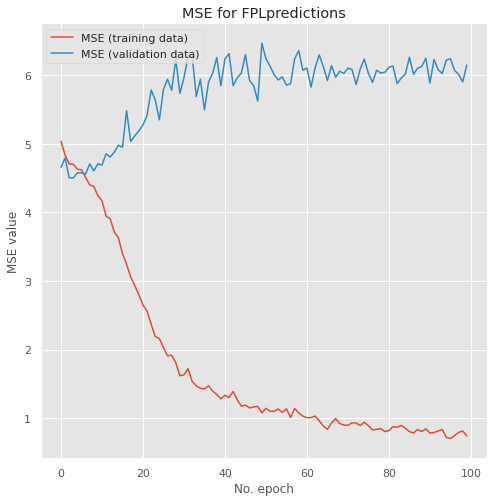

In [ ]:
fig = plt.figure(figsize = (8, 8))
plt.plot(history1.history['mean_squared_error'], label='MSE (training data)')
plt.plot(history1.history['val_mean_squared_error'], label='MSE (validation data)')
plt.title('MSE for FPLpredictions')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Treniranje, testiranje i cuvanje najboljeg modela

In [112]:
GBM_model_final = GradientBoostingRegressor(max_features= 11, n_estimators= 50, n_iter_no_change= 100, subsample= 1.0, validation_fraction= 0.2, random_state = 7)
GBM_model_final.fit(x_train_scaled, y_train)
y_pred_final = GBM_model_final.predict(x_test_scaled)

print("R2 score: " + str(metrics.r2_score(y_test, y_pred_final)))
print("MSE: " + str(metrics.mean_squared_error(y_test, y_pred_final)))

with open('models/GBM_model.sav','wb') as final_model:
  pickle.dump(GBM_model_final, final_model)

R2 score: 0.2866050684708288
MSE: 4.21236766907493


In [126]:
y_pred_gbm = GBM_model_final.predict(x_test_scaled)
objekat = {'pred': y_pred_gbm, 'true': y_test}
results = pd.DataFrame(data = objekat)
sortirani_poeni = results.sort_values(by=['pred'], ascending = False)
print('Najmanji izracunat broj poena: ' + str(np.array(sortirani_poeni)[-1][0]))
print('Najveci izracunat broj poena: ' + str(np.array(sortirani_poeni)[0][0]))

Najmanji izracunat broj poena: 0.032267868481287106
Najveci izracunat broj poena: 9.763231304600286


#Distribucija prediktovanih poena

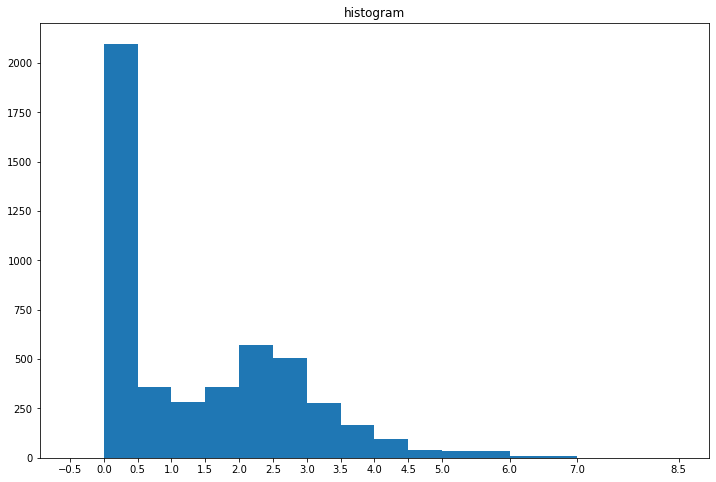

In [124]:
fig = plt.figure(figsize = (12, 8))
binare = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5 , 5, 6, 7, 8.5]
plt.hist(y_pred_gbm, bins = binare)
plt.xticks(binare)
plt.title("histogram") 
plt.show()

##Vaznosti atributa koje je dodelio GBM

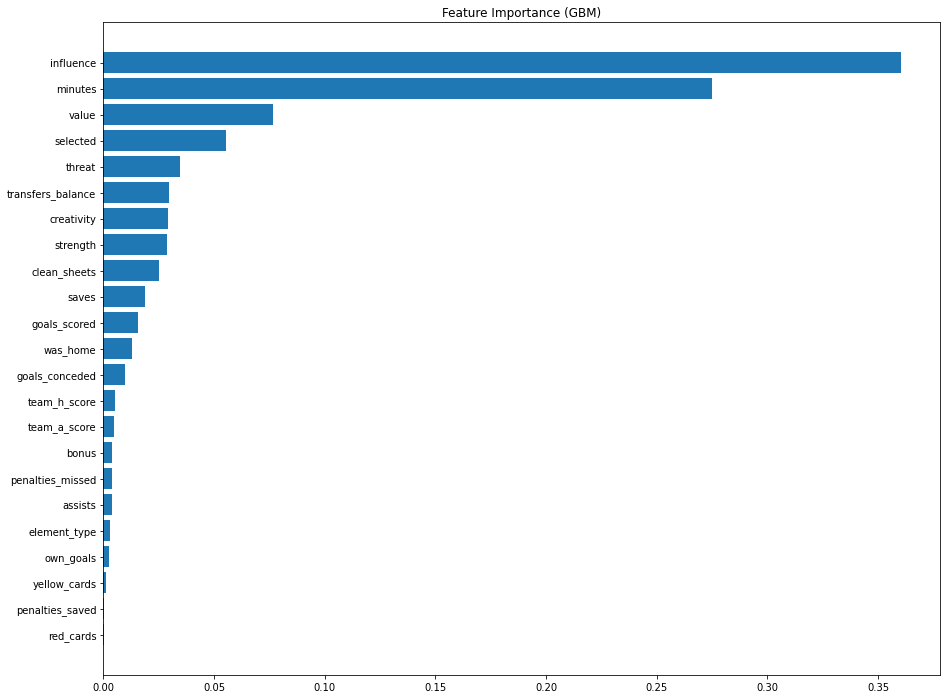

In [125]:
feature_importance = GBM_model_final.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(15, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x.columns)[sorted_idx])
plt.title('Feature Importance (GBM)')
plt.show()

#Kako se koji model pokazao?

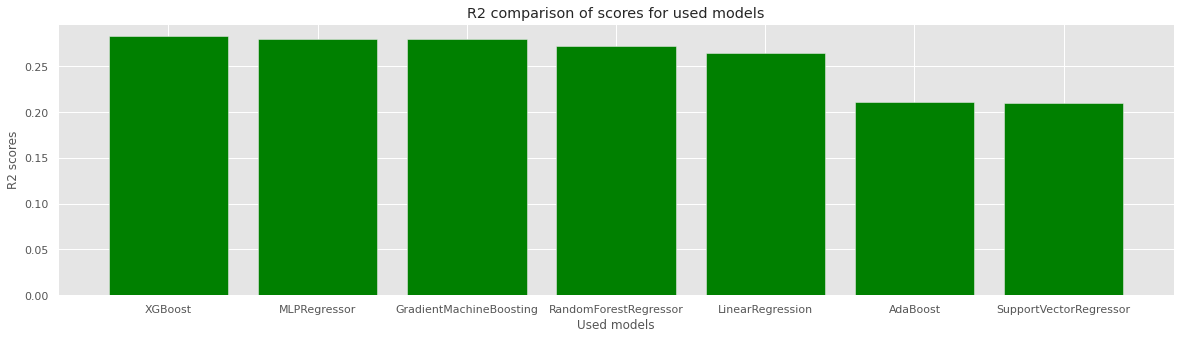

In [ ]:
r2_scores = np.array([svr_best_score, xg_best_score, RFR_best_score, Ada_best_score, lr_best_score, gbm_best_score, mlp_best_score])
model_names = ['SupportVectorRegressor', 'XGBoost', 'RandomForestRegressor', 'AdaBoost', 'LinearRegression', 'GradientMachineBoosting', 'MLPRegressor']

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 5))

model_names_pos = [i for i, _ in enumerate(model_names)]
n = len(r2_scores)
sorted_idx = r2_scores.argsort()[::-1][:n]
pos = np.arange(sorted_idx.shape[0])

plt.bar(model_names_pos, r2_scores[sorted_idx], color='green')
plt.xlabel("Used models")
plt.ylabel("R2 scores")
plt.title("R2 comparison of scores for used models")

plt.xticks(pos, np.array(model_names)[sorted_idx])

plt.show()

#Linear programming - izbor najboljeg tima

In [117]:
def get_player_instance(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks):
    df = pd.read_csv(file_path)
    df = df.drop(columns=columns_for_drop)
    if(df.shape[0] - last_weeks - 1 < 0):
        return pd.DataFrame(),0,0
    teams = pd.read_csv(teams_path)
    columns_teams = list(teams.columns)
    columns_teams.remove('id')
    columns_teams.remove('strength')
    teams = teams.drop(columns=columns_teams)
    
    
    payers_raw = pd.read_csv(payers_raw_path)
    columns_players_raw = list(payers_raw.columns)
    columns_players_raw.remove('id')
    columns_players_raw.remove('element_type')
    payers_raw = payers_raw.drop(columns=columns_players_raw)
    
    
    df = pd.merge(df, teams, left_on='opponent_team', right_on='id', how='left').drop(['opponent_team','id'],axis=1)
    df = pd.merge(df, payers_raw, left_on='element', right_on='id', how='left').drop(['element','id'],axis=1)
    df['minutes'] = np.where(df['minutes']>=60, 1, 0)

    df_element_type = df['element_type']
    df_strength = df['strength']
    df_total_points = df['total_points']
    df_was_home = df['was_home']
    dfs_only_last_week = df[only_last_week]
    df_left = df.drop(columns=(['element_type','strength','was_home','total_points']+only_last_week))
    df_right = pd.concat([df_element_type,df_strength, df_was_home,df_total_points], axis=1)

    
    columns_left = df_left.columns
    columns_middle = dfs_only_last_week.columns
    columns_right = df_right.columns
    
    data = df_left.to_numpy()
    n = data.shape[0]
    
    instance = np.copy(data[n-last_weeks-1])
    u = 1
    d = (last_weeks)*((last_weeks+1)/2)
    instance = instance * (u/d)
    for i in range(n-last_weeks,n-1):
        u+=1
        instance += data[i]*(u/d)
    instance = np.append(instance,np.array([x for x in dfs_only_last_week.iloc[n-2]]))
    instance = np.append(instance,np.array([df_right['element_type'][n-1],df_right['strength'][n-1],df_right['was_home'][n-1]]))
    columns = np.append(np.array(columns_left),np.array(columns_middle))
    columns = np.append(np.array(columns),np.array(columns_right))
    return (pd.DataFrame(instance.reshape(-1, len(instance)),columns=columns[:len(columns)-1]),df_left['value'][n-1]/10,df_right['element_type'][n-1])

In [118]:
def predict_points_for_players(root_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks = 5):
    skip_first = True
    playersFWD = {}
    playersMID = {}
    playersDEF = {}
    playersGLK = {}
    model = None
    with open('models/GBM_model.sav','rb') as pickle_model_forest:
        model = pickle.load(pickle_model_forest)
    for root, subdirs, files in os.walk(root_path):
        file_path = None
        if(skip_first):
            skip_first = False
            continue
        for file in files:
            if(file == 'gw.csv'):
                file_path = os.path.join(root,file)
        name = '_'.join(root.split('/')[len(root.split('/'))-1].split(' '))
        name = name.replace('-','_')
        
        if(file_path != None):
            instance,value,pos = get_player_instance(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks)
            if(instance.empty):
                continue
        
            points = model.predict(instance)[0]
            if(pos == 1):
                playersGLK[name] = {'price':value,'points':points,'position':'GLK'}
            elif(pos == 2):
                playersDEF[name] = {'price':value,'points':points,'position':'DEF'}
            elif(pos == 3):
                playersMID[name] = {'price':value,'points':points,'position':'MID'}
            elif(pos == 4):
                playersFWD[name] = {'price':value,'points':points,'position':'FWD'}
            
    return playersGLK,playersDEF,playersMID,playersFWD


In [119]:
columns_for_drop = ['bps','fixture','ict_index','kickoff_time','round','transfers_in','transfers_out']
only_last_week = ['creativity','influence','threat']
playersGLK,playersDEF,playersMID,playersFWD = predict_points_for_players('players/','teams.csv','players_raw.csv',columns_for_drop,only_last_week,2)
all_players = {}
all_players.update(playersFWD)
all_players.update(playersMID)
all_players.update(playersDEF)
all_players.update(playersGLK)
#print(all_players)

In [120]:
import pulp

variablesFWD = [pulp.LpVariable(p, cat='Binary') for p in playersFWD]
variablesMID = [pulp.LpVariable(p, cat='Binary') for p in playersMID]
variablesDEF = [pulp.LpVariable(p, cat='Binary') for p in playersDEF]
variablesGLK = [pulp.LpVariable(p, cat='Binary') for p in playersGLK]
all_variables = variablesFWD+variablesMID+variablesDEF+variablesGLK
players_sum = []
players_price = []
for v in all_variables:
    players_sum.append(all_players[str(v)]['points']*v)
    players_price.append(all_players[str(v)]['price']*v)
best_players_15 = pulp.LpProblem("Best_FPL_players_15", pulp.LpMaximize)
best_players_15 += pulp.lpSum(players_sum)
best_players_15 += pulp.lpSum(players_price) <= 100.00
best_players_15 += pulp.lpSum(variablesFWD) == 3
best_players_15 += pulp.lpSum(variablesMID) == 5
best_players_15 += pulp.lpSum(variablesDEF) == 5
best_players_15 += pulp.lpSum(variablesGLK) == 2
status_15 = best_players_15.solve()
pulp.LpStatus[status_15]
selected_15 = []
for p in all_variables:
    if(pulp.value(p) == 1):
        selected_15.append(str(p))
for s in selected_15:
    print(s,all_players[s])

Chris_Wood_91 {'price': 6.2, 'points': 9.918711258778774, 'position': 'FWD'}
Che_Adams_437 {'price': 5.3, 'points': 10.210934564320262, 'position': 'FWD'}
Danny_Ings_313 {'price': 7.6, 'points': 9.918711258778774, 'position': 'FWD'}
Christian_Pulisic_431 {'price': 7.4, 'points': 10.78262020967625, 'position': 'MID'}
Kevin_De_Bruyne_215 {'price': 10.6, 'points': 10.597844584663173, 'position': 'MID'}
Bernardo_Mota_Veiga_de_Carvalho_e_Silva_218 {'price': 7.6, 'points': 10.752334195689984, 'position': 'MID'}
Raheem_Sterling_214 {'price': 12.0, 'points': 10.752334195689984, 'position': 'MID'}
Rodrigo_Hernandez_443 {'price': 5.3, 'points': 10.597844584663173, 'position': 'MID'}
Reece_James_506 {'price': 4.9, 'points': 10.123557205522951, 'position': 'DEF'}
Marcos_Alonso_103 {'price': 6.1, 'points': 9.94600980852834, 'position': 'DEF'}
João_Pedro_Cavaco_Cancelo_518 {'price': 5.1, 'points': 10.597844584663173, 'position': 'DEF'}
Ryan_Bertrand_305 {'price': 4.8, 'points': 10.078702237883336, '

In [121]:
def get_team_11(playersGLK,playersDEF,playersMID,playersFWD,deff,mid,fwd,price):
    all_players = {}
    all_players.update(playersFWD)
    all_players.update(playersMID)
    all_players.update(playersDEF)
    all_players.update(playersGLK)
    variablesFWD = [pulp.LpVariable(p, cat='Binary') for p in playersFWD]
    variablesMID = [pulp.LpVariable(p, cat='Binary') for p in playersMID]
    variablesDEF = [pulp.LpVariable(p, cat='Binary') for p in playersDEF]
    variablesGLK = [pulp.LpVariable(p, cat='Binary') for p in playersGLK]
    all_variables = variablesFWD+variablesMID+variablesDEF+variablesGLK
    players_sum = []
    players_price = []
    for v in all_variables:
        players_sum.append(all_players[str(v)]['points']*v)
        players_price.append(all_players[str(v)]['price']*v)
    best_players = pulp.LpProblem("Best_FPL_players_"+str(deff)+str(mid)+str(fwd), pulp.LpMaximize)
    best_players += pulp.lpSum(players_sum)
    best_players += pulp.lpSum(players_price) <= price
    best_players += pulp.lpSum(variablesFWD) == fwd
    best_players += pulp.lpSum(variablesMID) == mid
    best_players += pulp.lpSum(variablesDEF) == deff
    best_players += pulp.lpSum(variablesGLK) == 1
    status = best_players.solve()
    pulp.LpStatus[status]
    selected = []
    for p in all_variables:
        if(pulp.value(p) == 1):
            selected.append(str(p))
    return selected

In [122]:
def choose_best_formation(formations):
    teams = []
    price = 85.0
    for f in formations:
        deff = int(f/100)
        mid = int(f/10)%10
        fwd = f%10
        team = get_team_11(playersGLK,playersDEF,playersMID,playersFWD,deff,mid,fwd,price)
        teams.append((team,''+str(deff)+'-'+str(mid)+'-'+str(fwd)))
    best_formation = None
    best_formation_points = None
    best_formation_label = None
    for (t,l) in teams:
        team_p = 0.0
        for s in t:
            team_p += all_players[s]['points']
        if(best_formation == None):
            best_formation = t
            best_formation_points = team_p
            best_formation_label = l
        elif(best_formation_points < team_p):
            best_formation = t
            best_formation_points = team_p
            best_formation_label = l

    print('Best team')
    print(best_formation_label)
    for s in best_formation:
        print(s,all_players[s])

    print()
    print('All teams')
    for (t,l) in teams:
        print(l)
        for s in t:
            print(s,all_players[s])
        print()

In [123]:
formations = [433,532,352,343,541]
choose_best_formation(formations)

Best team
3-5-2
Che_Adams_437 {'price': 5.3, 'points': 10.210934564320262, 'position': 'FWD'}
Danny_Ings_313 {'price': 7.6, 'points': 9.918711258778774, 'position': 'FWD'}
Christian_Pulisic_431 {'price': 7.4, 'points': 10.78262020967625, 'position': 'MID'}
Kevin_De_Bruyne_215 {'price': 10.6, 'points': 10.597844584663173, 'position': 'MID'}
Bernardo_Mota_Veiga_de_Carvalho_e_Silva_218 {'price': 7.6, 'points': 10.752334195689984, 'position': 'MID'}
Raheem_Sterling_214 {'price': 12.0, 'points': 10.752334195689984, 'position': 'MID'}
Rodrigo_Hernandez_443 {'price': 5.3, 'points': 10.597844584663173, 'position': 'MID'}
Reece_James_506 {'price': 4.9, 'points': 10.123557205522951, 'position': 'DEF'}
João_Pedro_Cavaco_Cancelo_518 {'price': 5.1, 'points': 10.597844584663173, 'position': 'DEF'}
Ryan_Bertrand_305 {'price': 4.8, 'points': 10.078702237883336, 'position': 'DEF'}
Jordan_Pickford_148 {'price': 5.2, 'points': 8.341621273551166, 'position': 'GLK'}

All teams
4-3-3
Chris_Wood_91 {'price':